#### By: Peyman Shahidi
#### Created: Oct 21, 2025
#### Last Edit: Oct 21, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots/taskSequence_vs_anthropicIndex"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Read O*NET data
ONET = pd.read_csv(f'{input_data_path}/computed_objects/ONET_cleaned_tasks.csv')

# Drop  columns to avoid double counting
# Note: In ~4k instances, the same task is mapped to multiple DWAs
ONET = ONET.drop(columns=['DWA ID', 'DWA Title'])

# Remove duplicate rows
rows_before = len(ONET)
print(f"Number of rows before removing duplicates: {rows_before:,}")
ONET = ONET.drop_duplicates().reset_index(drop=True)
rows_after = len(ONET)
print(f"Number of rows after removing duplicates: {rows_after:,}")
print(f"Duplicates removed: {rows_before - rows_after}")

# Print length of dataset
print(f"Number of rows in ONET dataset: {len(ONET):,}")

ONET.head(5)

Number of rows before removing duplicates: 22,310
Number of rows after removing duplicates: 17,953
Duplicates removed: 4357
Number of rows in ONET dataset: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Relevance,Base_SOC_Code,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,94.19,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,98.79,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,100.00,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,95.84,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,90.47,11-1011,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives


In [5]:
# Load GPTs are GPTs full label dataset
gpts_full_labels = pd.read_csv(f'{input_data_path}/GPTs-are-GPTs-main/data/full_labelset.tsv', sep="\t")

# Keep relevant columns only
gpts_full_labels = gpts_full_labels[['O*NET-SOC Code', 'Task ID', 'Task', 'Task Type', 'Title', 'gpt4_exposure', 'human_labels']]

# Convert Task ID to integer
gpts_full_labels['Task ID'] = gpts_full_labels['Task ID'].astype(int)

# Remove apostrophes for consistency
gpts_full_labels = gpts_full_labels.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

# Rename columns
gpts_full_labels = gpts_full_labels.rename(columns={
    'Task': 'Task Title',
    'Title': 'Occupation Title'
})

# Print length of dataset
print(f"Number of rows in GPTs full labels dataset: {len(gpts_full_labels):,}")


gpts_full_labels.head(5)

Number of rows in GPTs full labels dataset: 19,265


,O*NET-SOC Code,Task ID,Task Title,Task Type,Occupation Title,gpt4_exposure,human_labels
0,11-1011.00,8823,Direct or coordinate an organizations financia...,Core,Chief Executives,E2,E0
1,11-1011.00,8831,Appoint department heads or managers and assig...,Core,Chief Executives,E0,E0
2,11-1011.00,8825,Analyze operations to evaluate performance of ...,Core,Chief Executives,E2,E2
3,11-1011.00,8826,"Direct, plan, or implement policies, objective...",Core,Chief Executives,E2,E0
4,11-1011.00,8827,"Prepare budgets for approval, including those ...",Core,Chief Executives,E2,E2


In [6]:
# Merge with ONET dataset to get hierarchical codes and titles
ONET = ONET.merge(gpts_full_labels, on=['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type'], how='left')

# Check how many tasks were not matched
unmatched_tasks = ONET[ONET['gpt4_exposure'].isna()]
print(f"Number of unmatched tasks: {len(unmatched_tasks):,}")

Number of unmatched tasks: 791


In [7]:
ONET

,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Major_Group_Code,Major_Group_Title,Minor_Group_Code,Minor_Group_Title,Broad_Occupation_Code,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,NaN,NaN
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E0,E0
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E0
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,11-0000,Management Occupations,11-1000,Top Executives,11-1010,Chief Executives,11-1011,Chief Executives,E2,E2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17948,53-7121.00,"Tank Car, Truck, and Ship Loaders",12806,"Test vessels for leaks, damage, and defects, a...",Supplemental,2,4.96,29.10,18.68,22.35,...,53-0000,Transportation and Material Moving Occupations,53-7100,NaN,53-7120,"Tank Car, Truck, and Ship Loaders",53-7121,"Tank Car, Truck, and Ship Loaders",E0,E0
17949,53-7121.00,"Tank Car, Truck, and Ship Loaders",12807,Unload cars containing liquids by connecting h...,Supplemental,2,2.11,29.10,18.68,22.35,...,53-0000,Transportation and Material Moving Occupations,53-7100,NaN,53-7120,"Tank Car, Truck, and Ship Loaders",53-7121,"Tank Car, Truck, and Ship Loaders",E0,E0
17950,53-7121.00,"Tank Car, Truck, and Ship Loaders",12808,Copy and attach load specifications to loaded ...,Supplemental,2,5.04,29.10,18.68,22.35,...,53-0000,Transportation and Material Moving Occupations,53-7100,NaN,53-7120,"Tank Car, Truck, and Ship Loaders",53-7121,"Tank Car, Truck, and Ship Loaders",E0,E2
17951,53-7121.00,"Tank Car, Truck, and Ship Loaders",12809,Start pumps and adjust valves or cables to reg...,Core,2,6.93,29.10,18.68,22.35,...,53-0000,Transportation and Material Moving Occupations,53-7100,NaN,53-7120,"Tank Car, Truck, and Ship Loaders",53-7121,"Tank Car, Truck, and Ship Loaders",E0,E0


In [8]:
# Merge with Anthropic exposure data
anthropic_exposure = pd.read_csv(f'{input_data_path}/Anthropic_EconomicIndex/automation_vs_augmentation_by_task.csv')

# Remove if all entries are filtered:
anthropic_exposure = anthropic_exposure[anthropic_exposure['filtered'] != 1].reset_index(drop=True)

# Create new columns:
# Sum feedback loop and directive into Automation
# Sum validation, iteration, and learning into Augmentation
anthropic_exposure['automation'] = anthropic_exposure.apply(lambda row: row['feedback_loop'] + row['directive'], axis=1)
anthropic_exposure['augmentation'] = anthropic_exposure.apply(lambda row: row['validation'] + row['task_iteration'] + row['learning'], axis=1)

# Assign labels: take the max of automation, augmentation, manual and assign the corresponding label
def assign_label(row):
    max_value = max(row['automation'], row['augmentation'])
    if max_value == row['automation']:
        return 'Automation'
    elif max_value == row['augmentation']:
        return 'Augmentation'

anthropic_exposure['label'] = anthropic_exposure.apply(assign_label, axis=1)

# Filter to only keep the relevant columns
anthropic_exposure = anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']]
anthropic_exposure

,task_name,automation,augmentation,label
0,act as advisers to student organizations.,0.38,0.36,Automation
1,act as an intermediary in negotiations between...,0.39,0.43,Augmentation
2,act as an intermediary in negotiations between...,0.39,0.38,Automation
3,act as liaisons between on-site managers or te...,0.56,0.00,Automation
4,adapt instructional content or delivery method...,0.29,0.70,Augmentation
...,...,...,...,...
2293,"write, prepare, and deliver statements for the...",0.00,0.79,Augmentation
2294,"write, present, and publish reports that recor...",0.51,0.47,Automation
2295,"write, review, or execute plans for testing ne...",0.40,0.00,Automation
2296,"write, review, or maintain engineering documen...",0.35,0.62,Augmentation


In [9]:
# Print number of unique tasks in ONET dataset
print(f"Number of unique tasks in ONET dataset: {ONET['Task Title'].nunique():,}")

# Print number of unique tasks in Anthropic exposure dataset
print(f"Number of unique tasks in Anthropic exposure dataset: {anthropic_exposure['task_name'].nunique():,}")


# Add normalized task title to ONET for merging
ONET["task_normalized"] = ONET["Task Title"].str.lower().str.strip()


# Merge ONET and Anthropic exposure data on the normalized task title
merged_data = pd.merge(ONET, anthropic_exposure[['task_name', 'automation', 'augmentation', 'label']], left_on="task_normalized", right_on="task_name", how="left")

# Fill the NaN values of the label column in merged dataset as Manual
merged_data['label'] = merged_data['label'].fillna('Manual')

# Print distribution after filling NaN values
print(f"\nDistribution of labels after filling NaN values with 'Manual':")
print(merged_data['label'].value_counts())
print(f"Total tasks: {len(merged_data):,}")

merged_data.head()

Number of unique tasks in ONET dataset: 16,913
Number of unique tasks in Anthropic exposure dataset: 2,298

Distribution of labels after filling NaN values with 'Manual':
label
Manual          15605
Augmentation     1626
Automation        722
Name: count, dtype: int64
Total tasks: 17,953


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Broad_Occupation_Title,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,Chief Executives,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual


In [10]:
# Read task sequence data
# Go through computed_objects/tasks_sequences and read all files and merge with original ONET data
# Get list of files in the directory
task_sequence_files = [f for f in os.listdir(f'{input_data_path}/computed_objects/tasks_sequences') if f.endswith('.csv')]
task_sequence = pd.concat([pd.read_csv(f'{input_data_path}/computed_objects/tasks_sequences/{file}') for file in task_sequence_files], ignore_index=True)

print(f"Task sequence data shape: {task_sequence.shape}")
print(f"Columns in task sequence: {list(task_sequence.columns)}")

# Merge task sequence data with merged_data
merged_data = pd.merge(merged_data, task_sequence[['O*NET-SOC Code', 'Task ID', 'Task Position']], on=['O*NET-SOC Code', 'Task ID'], how='left')
merged_data = merged_data[merged_data['Task Position'].notna()].reset_index(drop=True)
merged_data.head(5)

Task sequence data shape: (16659, 5)
Columns in task sequence: ['Task Position', 'Task Title', 'Task ID', 'O*NET-SOC Code', 'Occupation Title']


,O*NET-SOC Code,Occupation Title,Task ID,Task Title,Task Type,Job Zone,Task_Time_Percentage,Hourly_Mean_Wage,Hourly_P10_Wage,Hourly_P25_Wage,...,Detailed_Occupation_Code,Detailed_Occupation_Title,gpt4_exposure,human_labels,task_normalized,task_name,automation,augmentation,label,Task Position
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,5,9.62,124.47,38.46,62.90,...,11-1011,Chief Executives,NaN,NaN,direct or coordinate an organization's financi...,direct or coordinate an organization's financi...,0.35,0.57,Augmentation,12.00
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,5,9.49,124.47,38.46,62.90,...,11-1011,Chief Executives,E0,E0,"confer with board members, organization offici...","confer with board members, organization offici...",0.25,0.61,Augmentation,4.00
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,5,9.22,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E2,analyze operations to evaluate performance of ...,analyze operations to evaluate performance of ...,0.31,0.66,Augmentation,3.00
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,5,10.26,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E0,"direct, plan, or implement policies, objective...",NaN,NaN,NaN,Manual,6.00
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,5,1.46,124.47,38.46,62.90,...,11-1011,Chief Executives,E2,E2,"prepare budgets for approval, including those ...",NaN,NaN,NaN,Manual,10.00


In [11]:
# # Reshuffle task assignments while preserving SOC hierarchy structure
# # Each occupation unit (O*NET-SOC Code + hierarchy levels) stays intact, but tasks are randomly reassigned
# # COMPLETELY UNRESTRICTED: Each task assigned to random occupation, no constraints on tasks per occupation

# # Create a copy of the data for reshuffling
# reshuffled_data = merged_data.copy()

# # Create SOC hierarchy levels with descriptive names from the O*NET-SOC Code
# reshuffled_data['soc_major_group'] = reshuffled_data['O*NET-SOC Code'].str[:2]
# reshuffled_data['soc_minor_group'] = reshuffled_data['O*NET-SOC Code'].str[:5] 
# reshuffled_data['soc_broad_occupation'] = reshuffled_data['O*NET-SOC Code'].str[:8]
# reshuffled_data['soc_detailed_occupation'] = reshuffled_data['O*NET-SOC Code']

# # Get unique occupation units (with all hierarchy levels intact)
# occupation_units = reshuffled_data[['O*NET-SOC Code', 'Occupation Title', 'soc_major_group', 
#                                    'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']].drop_duplicates()

# print(f"Number of unique occupation units: {len(occupation_units):,}")

# # Get all unique tasks (each task appears only once)
# unique_tasks = reshuffled_data[['Task ID', 'Task Title', 'Task Type', 'gpt4_exposure', 
#                                'human_labels', 'task_normalized', 'task_name', 
#                                'automation', 'augmentation', 'label']].drop_duplicates()

# print(f"Number of unique tasks: {len(unique_tasks):,}")

# # Set random seed for reproducibility
# np.random.seed(42)

# # UNRESTRICTED ASSIGNMENT: Each task randomly assigned to any occupation unit
# # No constraints on how many tasks per occupation
# n_tasks = len(unique_tasks)
# n_occupations = len(occupation_units)

# # Random assignment: each task gets assigned to a completely random occupation
# random_occupation_indices = np.random.choice(n_occupations, size=n_tasks, replace=True)

# print(f"Assigning {n_tasks:,} tasks randomly across {n_occupations:,} occupation units")

# # Create the reshuffled dataset
# reshuffled_list = []

# for task_idx in range(n_tasks):
#     occ_idx = random_occupation_indices[task_idx]
    
#     # Get task information
#     task_row = unique_tasks.iloc[task_idx].to_dict()
    
#     # Get occupation information  
#     occ_row = occupation_units.iloc[occ_idx].to_dict()
    
#     # Combine them
#     combined_row = {**task_row, **occ_row}
#     reshuffled_list.append(combined_row)

# # Create the reshuffled DataFrame
# reshuffled_data = pd.DataFrame(reshuffled_list)

# print(f"Reshuffled dataset created with {len(reshuffled_data):,} rows")

# # Verify the reshuffling worked correctly
# print(f"\nOriginal dataset task distribution by occupation:")
# original_task_counts = merged_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {original_task_counts.min()}")
# print(f"Max tasks per occupation: {original_task_counts.max()}")
# print(f"Mean tasks per occupation: {original_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {original_task_counts.std():.2f}")

# print(f"\nReshuffled dataset task distribution by occupation:")
# reshuffled_task_counts = reshuffled_data.groupby('O*NET-SOC Code')['Task ID'].nunique()
# print(f"Min tasks per occupation: {reshuffled_task_counts.min()}")
# print(f"Max tasks per occupation: {reshuffled_task_counts.max()}")
# print(f"Mean tasks per occupation: {reshuffled_task_counts.mean():.2f}")
# print(f"Std tasks per occupation: {reshuffled_task_counts.std():.2f}")

# # Count occupations with zero tasks
# zero_task_occupations = (reshuffled_task_counts == 0).sum()
# print(f"Occupations with zero tasks: {zero_task_occupations}")

# print(f"\nVerification:")
# print(f"Number of unique occupations preserved: {reshuffled_data['O*NET-SOC Code'].nunique() == merged_data['O*NET-SOC Code'].nunique()}")
# print(f"Number of unique tasks preserved: {reshuffled_data['Task ID'].nunique() == unique_tasks['Task ID'].nunique()}")
# print(f"Each task appears exactly once: {len(reshuffled_data) == len(unique_tasks)}")

# # Show SOC hierarchy column names
# print(f"\nSOC hierarchy columns created:")
# soc_columns = ['soc_major_group', 'soc_minor_group', 'soc_broad_occupation', 'soc_detailed_occupation']
# for col in soc_columns:
#     print(f"  {col}: {reshuffled_data[col].nunique():,} unique values")


# # Set reshuffled data as the final dataset
# merged_data = reshuffled_data.copy()

# # Show sample of reshuffled data
# print(f"\nSample of reshuffled data:")
# reshuffled_data.head()

In [12]:
# Drop the supplemental tasks
merged_data = merged_data[merged_data['Task Type'] != 'Supplemental'].reset_index(drop=True)

# Drop rows whose Occupation Title includes 'Teachers, Postsecondary'
merged_data = merged_data[~merged_data['Occupation Title'].str.contains('Teachers, Postsecondary')].reset_index(drop=True)

In [13]:
# # Only keep data for high AI-exposure major groups
# high_ai_exposure_major_groups = ['13-0000', '15-0000', '19-0000', '21-0000', '23-0000', '25-0000', '27-0000', '41-0000', '43-0000']
# merged_data = merged_data[merged_data['Major_Group_Code'].isin(high_ai_exposure_major_groups)].reset_index(drop=True)

In [14]:
# Check the final merged data structure and explore some sample occupations
print(f"Final merged data shape: {merged_data.shape}")
print(f"Columns: {list(merged_data.columns)}")
print(f"\nLabel distribution:")
print(merged_data['label'].value_counts())

# Find occupations with good task sequences (have multiple tasks with position data)
occupation_task_counts = merged_data.groupby(['O*NET-SOC Code', 'Occupation Title']).size().reset_index(name='task_count')
occupation_task_counts = occupation_task_counts.sort_values('task_count', ascending=False)
print(f"\nTop 10 occupations by task count:")
print(occupation_task_counts.head(10))

# Select a few example occupations for visualization
example_occupations = occupation_task_counts.head(5)['O*NET-SOC Code'].tolist()
print(f"\nSelected example occupations: {example_occupations}")

# Show sample data for first occupation
sample_occ_code = example_occupations[0]
sample_data = merged_data[merged_data['O*NET-SOC Code'] == sample_occ_code].copy()
sample_data = sample_data.sort_values('Task Position')
print(f"\nSample data for {sample_data['Occupation Title'].iloc[0]}:")
sample_data[['Task Position', 'Task Title', 'label']].head(10)

Final merged data shape: (11629, 45)
Columns: ['O*NET-SOC Code', 'Occupation Title', 'Task ID', 'Task Title', 'Task Type', 'Job Zone', 'Task_Time_Percentage', 'Hourly_Mean_Wage', 'Hourly_P10_Wage', 'Hourly_P25_Wage', 'Hourly_Median_Wage', 'Hourly_P75_Wage', 'Hourly_P90_Wage', 'Annual_Mean_Wage', 'Annual_P10_Wage', 'Annual_P25_Wage', 'Annual_Median_Wage', 'Annual_P75_Wage', 'Annual_P90_Wage', 'FT_Daily', 'FT_Hourly or more', 'FT_More than monthly', 'FT_More than weekly', 'FT_More than yearly', 'FT_Several times daily', 'FT_Yearly or less', 'Importance', 'Relevance', 'Base_SOC_Code', 'Major_Group_Code', 'Major_Group_Title', 'Minor_Group_Code', 'Minor_Group_Title', 'Broad_Occupation_Code', 'Broad_Occupation_Title', 'Detailed_Occupation_Code', 'Detailed_Occupation_Title', 'gpt4_exposure', 'human_labels', 'task_normalized', 'task_name', 'automation', 'augmentation', 'label', 'Task Position']

Label distribution:
label
Manual          10191
Augmentation     1064
Automation        374
Name: c

,Task Position,Task Title,label
4100,1.00,Collaborate with other teachers and administra...,Manual
4095,2.00,Prepare objectives and outlines for courses of...,Automation
4081,3.00,"Establish clear objectives for all lessons, un...",Manual
4083,4.00,Modify the general education curriculum for sp...,Manual
4082,5.00,Develop and implement strategies to meet the n...,Manual
4075,6.00,"Confer with parents, administrators, testing s...",Manual
4084,7.00,Meet with other professionals to discuss indiv...,Manual
4088,8.00,Coordinate placement of students with special ...,Manual
4090,9.00,Monitor teachers and teacher assistants to ens...,Manual
4096,10.00,Confer with other staff members to plan and sc...,Manual


In [15]:
# import os
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# from matplotlib.patches import Rectangle
# import numpy as np


# def plot_task_sequence(data, occ_code, title_max_length=50):
#     """Plot task sequence for a specific occupation with color-coded rectangles"""

#     # Filter and sort data for the occupation
#     occ_data = data[data['O*NET-SOC Code'] == occ_code].copy()
#     occ_data = occ_data.sort_values('Task Position')

#     if len(occ_data) == 0 or occ_data['Task Position'].isna().all():
#         print(f"No data with positions found for occupation {occ_code}")
#         return None

#     # Color mapping
#     color_map = {
#         'Manual': 'lightgray',
#         'Augmentation': 'orange',
#         'Automation': 'green'
#     }

#     # Create figure
#     fig, ax = plt.subplots(figsize=(16, max(6, len(occ_data) * 0.4)))

#     # Plot rectangles for each task
#     for i, (idx, row) in enumerate(occ_data.iterrows()):
#         y_pos = len(occ_data) - i - 1  # Start from top

#         # Create rectangle
#         rect = Rectangle((0, y_pos), 10, 0.8,
#                         facecolor=color_map.get(row['label'], 'lightgray'),
#                         edgecolor='black',
#                         linewidth=1)
#         ax.add_patch(rect)

#         # Truncate task title if too long
#         task_title = str(row['Task Title'])
#         if len(task_title) > title_max_length:
#             task_title = task_title[:title_max_length] + "..."

#         # Add task position number on the left
#         ax.text(-0.5, y_pos + 0.4, f"{int(row['Task Position'])}",
#                ha='right', va='center', fontweight='bold', fontsize=10)

#         # Add task title inside rectangle
#         ax.text(0.2, y_pos + 0.4, task_title,
#                ha='left', va='center', fontsize=9, wrap=True)

#         # Add label on the right
#         ax.text(10.2, y_pos + 0.4, row['label'],
#                ha='left', va='center', fontweight='bold', fontsize=9,
#                color=color_map.get(row['label'], 'black'))

#     # Set up the plot
#     ax.set_xlim(-2, 15)
#     ax.set_ylim(-0.5, len(occ_data) - 0.1)

#     # Remove axes
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

#     # Add title
#     occupation_title = occ_data['Occupation Title'].iloc[0]
#     plt.title(f"Task Sequence for {occupation_title}\n({occ_code})",
#              fontsize=14, fontweight='bold', pad=20)

#     # Add legend
#     legend_elements = [patches.Patch(color='lightgray', label='Manual'),
#                       patches.Patch(color='orange', label='Augmentation'),
#                       patches.Patch(color='green', label='Automation')]
#     ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

#     plt.tight_layout()
#     return fig


# # Create output subfolder for all occupation plots
# output_folder = os.path.join(output_plot_path, "all_occupation_task_sequences")
# os.makedirs(output_folder, exist_ok=True)

# # Iterate over all occupations and save plots
# occupations = merged_data['O*NET-SOC Code'].unique()
# print(f"Found {len(occupations):,} occupations to process. Plots will be saved to: {output_folder}")

# summary_rows = []
# for i, occ_code in enumerate(sorted(occupations)):
#     try:
#         occ_data = merged_data[merged_data['O*NET-SOC Code'] == occ_code].copy()
#         n_tasks = len(occ_data)
#         # Skip if no tasks or no position information
#         if n_tasks == 0 or occ_data['Task Position'].isna().all():
#             print(f"[{i+1}/{len(occupations)}] Skipping {occ_code}: no positional task data")
#             summary_rows.append({
#                 'O*NET-SOC Code': occ_code,
#                 'Occupation Title': occ_data['Occupation Title'].iloc[0] if len(occ_data) > 0 else '',
#                 'n_tasks': n_tasks,
#                 'manual': 0,
#                 'augmentation': 0,
#                 'automation': 0,
#                 'filename': '',
#                 'status': 'skipped_no_positions'
#             })
#             continue

#         occ_data = occ_data.sort_values('Task Position')

#         fig = plot_task_sequence(merged_data, occ_code)
#         if fig is None:
#             print(f"[{i+1}/{len(occupations)}] No figure produced for {occ_code}")
#             summary_rows.append({
#                 'O*NET-SOC Code': occ_code,
#                 'Occupation Title': occ_data['Occupation Title'].iloc[0],
#                 'n_tasks': n_tasks,
#                 'manual': occ_data['label'].value_counts().get('Manual', 0),
#                 'augmentation': occ_data['label'].value_counts().get('Augmentation', 0),
#                 'automation': occ_data['label'].value_counts().get('Automation', 0),
#                 'filename': '',
#                 'status': 'no_figure'
#             })
#             continue

#         # Safe filename
#         occ_title = occ_data['Occupation Title'].iloc[0]
#         safe_title = ''.join(c if (c.isalnum() or c in (' ', '_', '-')) else '_' for c in occ_title).replace(' ', '_')[:120]
#         filename = os.path.join(output_folder, f"task_sequence_{occ_code}_{safe_title}.png")

#         # Save and close
#         fig.savefig(filename, dpi=300, bbox_inches='tight')
#         plt.close(fig)

#         counts = occ_data['label'].value_counts()
#         summary_rows.append({
#             'O*NET-SOC Code': occ_code,
#             'Occupation Title': occ_title,
#             'n_tasks': n_tasks,
#             'manual': counts.get('Manual', 0),
#             'augmentation': counts.get('Augmentation', 0),
#             'automation': counts.get('Automation', 0),
#             'filename': filename,
#             'status': 'saved'
#         })

#         if (i + 1) % 50 == 0:
#             print(f"Processed {i+1}/{len(occupations)} occupations")

#     except Exception as e:
#         print(f"Error processing {occ_code}: {e}")
#         summary_rows.append({
#             'O*NET-SOC Code': occ_code,
#             'Occupation Title': occ_data['Occupation Title'].iloc[0] if 'occ_data' in locals() and len(occ_data) > 0 else '',
#             'n_tasks': len(occ_data) if 'occ_data' in locals() else 0,
#             'manual': occ_data['label'].value_counts().get('Manual', 0) if 'occ_data' in locals() else 0,
#             'augmentation': occ_data['label'].value_counts().get('Augmentation', 0) if 'occ_data' in locals() else 0,
#             'automation': occ_data['label'].value_counts().get('Automation', 0) if 'occ_data' in locals() else 0,
#             'filename': '',
#             'status': 'error',
#             'error_msg': str(e)
#         })

# # # Save summary CSV
# # summary_df = pd.DataFrame(summary_rows)
# # summary_csv_path = os.path.join(output_folder, 'task_sequence_summary.csv')
# # summary_df.to_csv(summary_csv_path, index=False)
# # print(f"Saved summary CSV with {len(summary_df)} rows to: {summary_csv_path}")
# # print("Done. Open the notebook and run this cell (or execute the notebook) to generate the plots.")


### Calculate some measures of fragmentation: 
1) What fraction of automated tasks are followed by an augmented task?
2) What fraction of automated tasks have an augmented task either before or after them (must be weakly higher than previous measure)?
3) What's the distribution of length of AI chains (augmented or automated)?

In [16]:
# Compute fragmentation measures by occupation
import os
from collections import Counter, defaultdict

# We'll operate on the 'merged_data' DataFrame which already contains:
# - 'O*NET-SOC Code' (occupation code)
# - 'Task ID'
# - 'Task Position' (numeric position within the occupation)
# - 'label' with values 'Automation', 'Augmentation', or 'Manual'

# Ensure Task Position is numeric and drop rows missing it (should already be filtered above)
merged_data['Task Position'] = pd.to_numeric(merged_data['Task Position'], errors='coerce')
data_with_pos = merged_data[merged_data['Task Position'].notna()].copy()

# Group by occupation and compute measures
results = []
ai_chain_lengths = defaultdict(list)  # occ_code -> list of chain lengths

for occ_code, occ_df in data_with_pos.groupby('O*NET-SOC Code'):
    occ_df = occ_df.sort_values('Task Position').reset_index(drop=True)
    labels = occ_df['label'].tolist()

    # Positions of automation and augmentation tasks
    is_auto = [1 if l == 'Automation' else 0 for l in labels]
    is_aug = [1 if l == 'Augmentation' else 0 for l in labels]

    # counts
    n_automation = sum(is_auto)
    n_augmentation = sum(is_aug)
    n_ai = n_automation + n_augmentation

    # 1) Fraction of automated tasks followed by an augmented task
    auto_indices = [i for i, v in enumerate(is_auto) if v == 1]
    if len(auto_indices) == 0:
        frac_followed = None
    else:
        followed_count = 0
        for i in auto_indices:
            if i + 1 < len(labels) and labels[i+1] == 'Augmentation':
                followed_count += 1
        frac_followed = followed_count / len(auto_indices)

    # 2) Fraction of automated tasks that have augmented before OR after (weakly higher)
    if len(auto_indices) == 0:
        frac_adjacent = None
    else:
        adjacent_count = 0
        for i in auto_indices:
            has_before = (i - 1 >= 0 and labels[i-1] == 'Augmentation')
            has_after = (i + 1 < len(labels) and labels[i+1] == 'Augmentation')
            if has_before or has_after:
                adjacent_count += 1
        frac_adjacent = adjacent_count / len(auto_indices)

    # 3) Distribution of AI chain lengths: each consecutive run of Automation or Augmentation
    #    counts as a single chain. For example, ...Manual, A, A, Aug, Manual... -> one chain of length 3.
    chains = []
    current_len = 0
    for l in labels:
        if l in ('Automation', 'Augmentation'):
            current_len += 1
        else:
            if current_len > 0:
                chains.append(current_len)  # append the run length once
                current_len = 0
    if current_len > 0:
        chains.append(current_len)

    # store chain lengths for occupation
    ai_chain_lengths[occ_code].extend(chains)

    results.append({
        'O*NET-SOC Code': occ_code,
        'Occupation Title': occ_df['Occupation Title'].iloc[0] if 'Occupation Title' in occ_df.columns else '',
        'n_tasks': len(labels),
        'n_ai': n_ai,
        'n_automation': n_automation,
        'n_augmentation': n_augmentation,
        'frac_auto_followed_by_aug': frac_followed,
        'frac_auto_adjacent_aug': frac_adjacent,
        'ai_chain_count': len(chains),
        'ai_chain_mean_length': np.mean(chains) if len(chains) > 0 else 0,
    })

# Create summary DataFrame
frag_df = pd.DataFrame(results)

# Flatten chain length distribution into a single DataFrame for analysis/plotting
chain_rows = []
for occ, lengths in ai_chain_lengths.items():
    for L in lengths:
        chain_rows.append({'O*NET-SOC Code': occ, 'chain_length': L})

chain_df = pd.DataFrame(chain_rows)

# Save results to computed_objects for later use
os.makedirs(f'{input_data_path}/computed_objects/fragmentation_measures', exist_ok=True)
frag_df.to_csv(f'{input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv', index=False)
chain_df.to_csv(f'{input_data_path}/computed_objects/fragmentation_measures/chain_length_distribution.csv', index=False)

print(f'Saved occupation fragmentation summary to: {input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv')
print(f'Saved chain length distribution to: {input_data_path}/computed_objects/fragmentation_measures/chain_length_distribution.csv')

# Show top occupations by number of AI chains and example statistics
print('Top occupations by AI chain count:')
display(frag_df.sort_values('ai_chain_count', ascending=False).head(10))

# Basic distribution summary of chain lengths across all occupations
if len(chain_df) > 0:
    print('Chain length distribution (counts):')
    display(chain_df['chain_length'].value_counts().sort_index())
else:
    print('No AI chains found in the dataset')


Saved occupation fragmentation summary to: ../data/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv
Saved chain length distribution to: ../data/computed_objects/fragmentation_measures/chain_length_distribution.csv
Top occupations by AI chain count:


,O*NET-SOC Code,Occupation Title,n_tasks,n_ai,n_automation,n_augmentation,frac_auto_followed_by_aug,frac_auto_adjacent_aug,ai_chain_count,ai_chain_mean_length
239,25-2021.00,"Elementary School Teachers, Except Special Edu...",36,12,9,3,0.11,0.11,9,1.33
241,25-2023.00,"Career/Technical Education Teachers, Middle Sc...",31,12,9,3,0.00,0.00,9,1.33
242,25-2031.00,"Secondary School Teachers, Except Special and ...",31,13,9,4,0.00,0.00,8,1.62
243,25-2032.00,"Career/Technical Education Teachers, Secondary...",33,11,8,3,0.00,0.00,8,1.38
237,25-2011.00,"Preschool Teachers, Except Special Education",32,7,4,3,0.00,0.00,7,1.00
102,15-1299.08,Computer Systems Engineers/Architects,28,12,1,11,0.00,0.00,7,1.71
486,43-4031.00,"Court, Municipal, and License Clerks",25,8,2,6,0.00,0.00,7,1.14
247,25-3011.00,"Adult Basic Education, Adult Secondary Educati...",29,10,5,5,0.20,0.20,7,1.43
240,25-2022.00,"Middle School Teachers, Except Special and Car...",34,13,9,4,0.11,0.11,7,1.86
245,25-2058.00,"Special Education Teachers, Secondary School",38,10,7,3,0.00,0.14,6,1.67


Chain length distribution (counts):


chain_length
1     796
2     168
3      50
4      24
5       4
6       2
8       1
9       1
11      1
Name: count, dtype: int64

In [ ]:
"""Check what fraction of automation tasks are followed by augmentation tasks, etc., per occupation."""


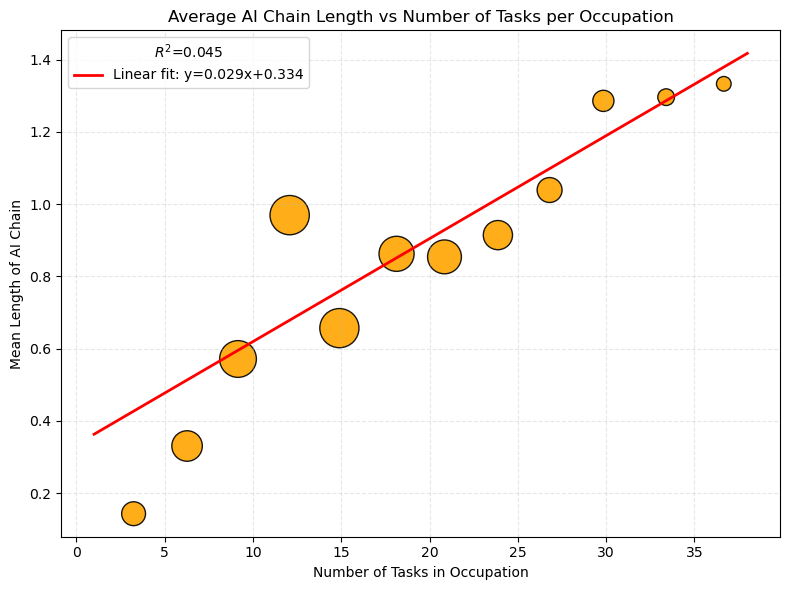

Saved binned scatter (12 bins) + regression to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/tasks_aiChainMeanLength.png


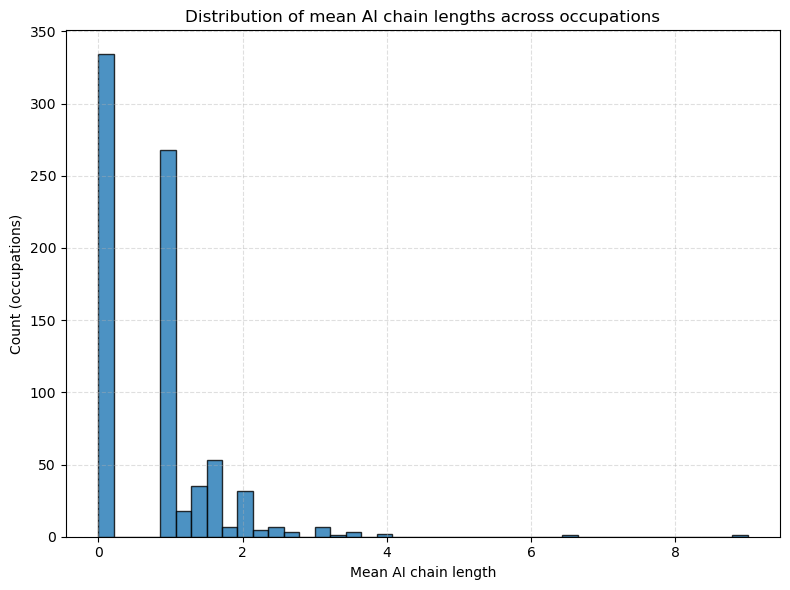

Saved histogram to: ../writeup/plots/taskSequence_vs_anthropicIndex/fragmentation/hist_aiChainMeanLength.png


In [17]:
# Binned scatter with 12 x-bins: bin centers vs mean AI chain length, point size ~ sqrt(count), alpha=0.05, plus regression
import numpy as np
import math

# Ensure frag_df exists
if 'frag_df' not in globals():
    frag_df = pd.read_csv(f'{input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv')

# Create output folder
plot_folder = os.path.join(output_plot_path, 'fragmentation')
os.makedirs(plot_folder, exist_ok=True)

# Prepare data (drop missing)
x_all = frag_df['n_tasks']
y_all = frag_df['ai_chain_mean_length']
mask = x_all.notna() & y_all.notna()
x = x_all[mask].astype(float)
y = y_all[mask].astype(float)

if len(x) == 0:
    print('No data available for binned scatter plot')
else:
    # Define 12 bins across x range
    n_bins = 12
    x_min, x_max = x.min(), x.max()
    if x_min == x_max:
        bins = np.linspace(x_min - 0.5, x_max + 0.5, n_bins + 1)
    else:
        bins = np.linspace(x_min, x_max, n_bins + 1)

    # Assign bins
    bin_idx = np.digitize(x, bins) - 1  # 0-based bin index; values == len(bins) go to last bin
    bin_idx[bin_idx < 0] = 0
    bin_idx[bin_idx >= n_bins] = n_bins - 1

    # Aggregate per bin: mean x, mean y, count
    bin_centers = []
    bin_means_y = []
    bin_counts = []
    for b in range(n_bins):
        sel = (bin_idx == b)
        cnt = sel.sum()
        if cnt == 0:
            # skip empty bins but keep placeholder
            bin_centers.append((bins[b] + bins[b+1]) / 2)
            bin_means_y.append(np.nan)
            bin_counts.append(0)
        else:
            bin_centers.append(x[sel].mean())
            bin_means_y.append(y[sel].mean())
            bin_counts.append(int(cnt))

    bin_centers = np.array(bin_centers)
    bin_means_y = np.array(bin_means_y)
    bin_counts = np.array(bin_counts)

    # Scale marker sizes by sqrt(counts) (normalize for plotting)
    # marker area proportional to sqrt(count)
    max_marker_area = 800  # max area size
    if bin_counts.max() > 0:
        sizes = np.sqrt(bin_counts)
        sizes = (sizes / sizes.max()) * max_marker_area
    else:
        sizes = np.full_like(bin_counts, 20, dtype=float)

    # Plot
    plt.figure(figsize=(8,6))

    # Overlay every observation as a low-opacity scatter (one marker per observation)
    # color 'steelblue' requested, alpha 0.05
    # plt.scatter(x, y, s=10, color='steelblue', alpha=0.05, edgecolors='none', label='Observations')

    # plot bin points; use alpha so bins are visible
    plt.scatter(bin_centers, bin_means_y, s=sizes, color='orange', alpha=0.9, edgecolors='k')

    # annotate counts optionally (commented out by default)
    # for i, c in enumerate(bin_counts):
    #     if c > 0:
    #         plt.text(bin_centers[i], bin_means_y[i], str(c), fontsize=8, ha='center', va='center')

    # Fit regression on raw points (x,y)
    try:
        coeffs = np.polyfit(x, y, 1)
        p = np.poly1d(coeffs)
        x_line = np.linspace(x.min(), x.max(), 200)
        y_line = p(x_line)
        plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}')

        # R^2
        y_pred = p(x)
        ss_res = ((y - y_pred) ** 2).sum()
        ss_tot = ((y - y.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
        plt.legend(title=f'$R^2$={r2:.3f}')
    except Exception as e:
        print('Regression fit failed:', e)

    plt.xlabel('Number of Tasks in Occupation')
    plt.ylabel('Mean Length of AI Chain')
    plt.title('Average AI Chain Length vs Number of Tasks per Occupation')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    binned_scatter_path = os.path.join(plot_folder, 'tasks_aiChainMeanLength.png')
    plt.savefig(binned_scatter_path, dpi=300)
    plt.show()
    print(f'Saved binned scatter (12 bins) + regression to: {binned_scatter_path}')

# Also keep the histogram below (unchanged)
plt.figure(figsize=(8,6))
values = frag_df['ai_chain_mean_length'].dropna()
if len(values) > 1:
    q25, q75 = np.percentile(values, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(values) ** (1/3)) if iqr > 0 else (values.max() - values.min()) / 30
    if bin_width <= 0:
        bins = 30
    else:
        bins = max(10, int(math.ceil((values.max() - values.min()) / bin_width)))
else:
    bins = 10

plt.hist(values, bins=bins, color='C0', edgecolor='k', alpha=0.8)
plt.xlabel('Mean AI chain length')
plt.ylabel('Count (occupations)')
plt.title('Distribution of mean AI chain lengths across occupations')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
hist_path = os.path.join(plot_folder, 'hist_aiChainMeanLength.png')
plt.savefig(hist_path, dpi=300)
plt.show()
print(f'Saved histogram to: {hist_path}')


In [18]:
# # Binned scatter with 12 x-bins: bin centers vs mean AI chain length, point size ~ sqrt(count), alpha=0.05, plus regression
# import numpy as np
# import math

# # Ensure frag_df exists
# if 'frag_df' not in globals():
#     frag_df = pd.read_csv(f'{input_data_path}/computed_objects/fragmentation_measures/occupation_fragmentation_summary.csv')

# # Create output folder
# plot_folder = os.path.join(output_plot_path, 'fragmentation')
# os.makedirs(plot_folder, exist_ok=True)

# # Prepare data (drop missing)

# x_all = frag_df[frag_df['ai_chain_mean_length'] > 0]['n_tasks']
# y_all = frag_df[frag_df['ai_chain_mean_length'] > 0]['ai_chain_mean_length']
# mask = x_all.notna() & y_all.notna()
# x = x_all[mask].astype(float)
# y = y_all[mask].astype(float)

# if len(x) == 0:
#     print('No data available for binned scatter plot')
# else:
#     # Define 12 bins across x range
#     n_bins = 12
#     x_min, x_max = x.min(), x.max()
#     if x_min == x_max:
#         bins = np.linspace(x_min - 0.5, x_max + 0.5, n_bins + 1)
#     else:
#         bins = np.linspace(x_min, x_max, n_bins + 1)

#     # Assign bins
#     bin_idx = np.digitize(x, bins) - 1  # 0-based bin index; values == len(bins) go to last bin
#     bin_idx[bin_idx < 0] = 0
#     bin_idx[bin_idx >= n_bins] = n_bins - 1

#     # Aggregate per bin: mean x, mean y, count
#     bin_centers = []
#     bin_means_y = []
#     bin_counts = []
#     for b in range(n_bins):
#         sel = (bin_idx == b)
#         cnt = sel.sum()
#         if cnt == 0:
#             # skip empty bins but keep placeholder
#             bin_centers.append((bins[b] + bins[b+1]) / 2)
#             bin_means_y.append(np.nan)
#             bin_counts.append(0)
#         else:
#             bin_centers.append(x[sel].mean())
#             bin_means_y.append(y[sel].mean())
#             bin_counts.append(int(cnt))

#     bin_centers = np.array(bin_centers)
#     bin_means_y = np.array(bin_means_y)
#     bin_counts = np.array(bin_counts)

#     # Scale marker sizes by sqrt(counts) (normalize for plotting)
#     # marker area proportional to sqrt(count)
#     max_marker_area = 800  # max area size
#     if bin_counts.max() > 0:
#         sizes = np.sqrt(bin_counts)
#         sizes = (sizes / sizes.max()) * max_marker_area
#     else:
#         sizes = np.full_like(bin_counts, 20, dtype=float)

#     # Plot
#     plt.figure(figsize=(8,6))

#     # Overlay every observation as a low-opacity scatter (one marker per observation)
#     # color 'steelblue' requested, alpha 0.05
#     # plt.scatter(x, y, s=10, color='steelblue', alpha=0.05, edgecolors='none', label='Observations')

#     # plot bin points; use alpha so bins are visible
#     plt.scatter(bin_centers, bin_means_y, s=sizes, color='orange', alpha=0.9, edgecolors='k')

#     # annotate counts optionally (commented out by default)
#     # for i, c in enumerate(bin_counts):
#     #     if c > 0:
#     #         plt.text(bin_centers[i], bin_means_y[i], str(c), fontsize=8, ha='center', va='center')

#     # Fit regression on raw points (x,y)
#     try:
#         coeffs = np.polyfit(x, y, 1)
#         p = np.poly1d(coeffs)
#         x_line = np.linspace(x.min(), x.max(), 200)
#         y_line = p(x_line)
#         plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Linear fit: y={coeffs[0]:.3f}x+{coeffs[1]:.3f}')

#         # R^2
#         y_pred = p(x)
#         ss_res = ((y - y_pred) ** 2).sum()
#         ss_tot = ((y - y.mean()) ** 2).sum()
#         r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
#         plt.legend(title=f'$R^2$={r2:.3f}')
#     except Exception as e:
#         print('Regression fit failed:', e)

#     plt.xlabel('Number of Tasks in Occupation')
#     plt.ylabel('Mean Length of AI Chain')
#     plt.title('Average AI Chain Length vs Number of Tasks per Occupation')
#     plt.grid(True, linestyle='--', alpha=0.3)
#     plt.tight_layout()
#     binned_scatter_path = os.path.join(plot_folder, 'tasks_aiChainMeanLength.png')
#     plt.savefig(binned_scatter_path, dpi=300)
#     plt.show()
#     print(f'Saved binned scatter (12 bins) + regression to: {binned_scatter_path}')

# # Also keep the histogram below (unchanged)
# plt.figure(figsize=(8,6))
# values = frag_df['ai_chain_mean_length'].dropna()
# if len(values) > 1:
#     q25, q75 = np.percentile(values, [25, 75])
#     iqr = q75 - q25
#     bin_width = 2 * iqr / (len(values) ** (1/3)) if iqr > 0 else (values.max() - values.min()) / 30
#     if bin_width <= 0:
#         bins = 30
#     else:
#         bins = max(10, int(math.ceil((values.max() - values.min()) / bin_width)))
# else:
#     bins = 10

# plt.hist(values, bins=bins, color='C0', edgecolor='k', alpha=0.8)
# plt.xlabel('Mean AI chain length')
# plt.ylabel('Count (occupations)')
# plt.title('Distribution of mean AI chain lengths across occupations')
# plt.grid(True, linestyle='--', alpha=0.4)
# plt.tight_layout()
# hist_path = os.path.join(plot_folder, 'hist_aiChainMeanLength.png')
# plt.savefig(hist_path, dpi=300)
# plt.show()
# print(f'Saved histogram to: {hist_path}')


In [19]:
# Five regressions: A-E (no FE, major FE, major FE+interactions, minor FE, minor FE+interactions).
import os
import sys

# Ensure statsmodels available
try:
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'statsmodels'])
    import statsmodels.formula.api as smf
    import statsmodels.api as sm

# Load frag_df if needed
if 'frag_df' not in globals():
    frag_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    print('Loading frag_df from:', frag_path)
    frag_df = pd.read_csv(frag_path)

# Coerce numeric
frag_df['n_tasks'] = pd.to_numeric(frag_df['n_tasks'], errors='coerce')
frag_df['ai_chain_mean_length'] = pd.to_numeric(frag_df['ai_chain_mean_length'], errors='coerce')

# Build major and minor group variables
frag_df['major_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
frag_df['minor_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:5] + '-000'

# Group small groups into 'Other' for both major and minor
min_count = 10
major_counts = frag_df['major_group'].value_counts()
large_majors = major_counts[major_counts >= min_count].index.tolist()
frag_df['major_group2'] = frag_df['major_group'].where(frag_df['major_group'].isin(large_majors), 'Other')

minor_counts = frag_df['minor_group'].value_counts()
large_minors = minor_counts[minor_counts >= min_count].index.tolist()
frag_df['minor_group2'] = frag_df['minor_group'].where(frag_df['minor_group'].isin(large_minors), 'Other')

# Regression dataframe
reg_df = frag_df.dropna(subset=['ai_chain_mean_length', 'n_tasks']).copy()
print(f'Regression dataset: {len(reg_df)} observations; unique major_group2: {reg_df["major_group2"].nunique()}')

# Output directory
base_out = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(base_out, exist_ok=True)

# Model A: no major-group fixed effects
print('\n=== Model A: no major-group fixed effects ===')
model_a = smf.ols('ai_chain_mean_length ~ n_tasks', data=reg_df).fit(cov_type='HC3')
print(model_a.summary())

# Save Model A outputs
with open(os.path.join(base_out, 'regression_A_noFE_summary.txt'), 'w') as f:
    f.write(model_a.summary().as_text())
coef_a = model_a.params.reset_index()
coef_a.columns = ['term', 'estimate']
coef_a['pvalue'] = model_a.pvalues.values
coef_a.to_csv(os.path.join(base_out, 'regression_A_noFE_coefficients.csv'), index=False)

# Model B: with major-group fixed effects (no interactions)
print('\n=== Model B: major-group fixed effects (C(major_group2)) ===')
model_b = smf.ols('ai_chain_mean_length ~ n_tasks + C(major_group2)', data=reg_df).fit(cov_type='HC3')
print(model_b.summary())
with open(os.path.join(base_out, 'regression_B_majorFE_summary.txt'), 'w') as f:
    f.write(model_b.summary().as_text())
coef_b = model_b.params.reset_index()
coef_b.columns = ['term', 'estimate']
coef_b['pvalue'] = model_b.pvalues.values
coef_b.to_csv(os.path.join(base_out, 'regression_B_majorFE_coefficients.csv'), index=False)

# # Model C: major-group fixed effects WITH interactions (allow slope to vary by major group)
# print('\n=== Model C: major-group FE + interactions (n_tasks * C(major_group2)) ===')
# model_c = smf.ols('ai_chain_mean_length ~ n_tasks * C(major_group2)', data=reg_df).fit(cov_type='HC3')
# print(model_c.summary())
# with open(os.path.join(base_out, 'regression_C_majorFE_interact_summary.txt'), 'w') as f:
#     f.write(model_c.summary().as_text())
# coef_c = model_c.params.reset_index()
# coef_c.columns = ['term', 'estimate']
# coef_c['pvalue'] = model_c.pvalues.values
# coef_c.to_csv(os.path.join(base_out, 'regression_C_majorFE_interact_coefficients.csv'), index=False)
# # Save interaction terms and compute group-specific slopes
# interaction_terms_c = [t for t in model_c.params.index if ':' in t or (t.startswith('n_tasks') and 'C(major_group2)' in t)]
# if len(interaction_terms_c) > 0:
#     inter_c = pd.DataFrame({
#         'term': interaction_terms_c,
#         'estimate': [model_c.params.get(t, float('nan')) for t in interaction_terms_c],
#         'pvalue': [model_c.pvalues.get(t, float('nan')) for t in interaction_terms_c]
#     })
#     inter_c.to_csv(os.path.join(base_out, 'regression_C_majorFE_interactions.csv'), index=False)
#     # compute per-major-group slopes: baseline n_tasks + each interaction term
#     base_slope_c = model_c.params.get('n_tasks', 0.0)
#     group_slopes = []
#     for g in sorted(reg_df['major_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_c
#         else:
#             term_name = f'n_tasks:C(major_group2)[T.{g}]'
#             slope = base_slope_c + model_c.params.get(term_name, 0.0)
#         group_slopes.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes).to_csv(os.path.join(base_out, 'regression_C_major_group_slopes.csv'), index=False)

# Model D: minor-group fixed effects (no interactions)
print('\n=== Model D: minor-group fixed effects (C(minor_group2)) ===')
model_d = smf.ols('ai_chain_mean_length ~ n_tasks + C(minor_group2)', data=reg_df).fit(cov_type='HC3')
print(model_d.summary())
with open(os.path.join(base_out, 'regression_D_minorFE_summary.txt'), 'w') as f:
    f.write(model_d.summary().as_text())
coef_d = model_d.params.reset_index()
coef_d.columns = ['term', 'estimate']
coef_d['pvalue'] = model_d.pvalues.values
coef_d.to_csv(os.path.join(base_out, 'regression_D_minorFE_coefficients.csv'), index=False)

# # Model E: minor-group fixed effects WITH interactions
# print('\n=== Model E: minor-group FE + interactions (n_tasks * C(minor_group2)) ===')
# model_e = smf.ols('ai_chain_mean_length ~ n_tasks * C(minor_group2)', data=reg_df).fit(cov_type='HC3')
# print(model_e.summary())
# with open(os.path.join(base_out, 'regression_E_minorFE_interact_summary.txt'), 'w') as f:
#     f.write(model_e.summary().as_text())
# coef_e = model_e.params.reset_index()
# coef_e.columns = ['term', 'estimate']
# coef_e['pvalue'] = model_e.pvalues.values
# coef_e.to_csv(os.path.join(base_out, 'regression_E_minorFE_interact_coefficients.csv'), index=False)
# # Save interaction terms and compute per-minor-group slopes
# interaction_terms_e = [t for t in model_e.params.index if ':' in t or (t.startswith('n_tasks') and 'C(minor_group2)' in t)]
# if len(interaction_terms_e) > 0:
#     inter_e = pd.DataFrame({
#         'term': interaction_terms_e,
#         'estimate': [model_e.params.get(t, float('nan')) for t in interaction_terms_e],
#         'pvalue': [model_e.pvalues.get(t, float('nan')) for t in interaction_terms_e]
#     })
#     inter_e.to_csv(os.path.join(base_out, 'regression_E_minorFE_interactions.csv'), index=False)
#     base_slope_e = model_e.params.get('n_tasks', 0.0)
#     group_slopes_e = []
#     for g in sorted(reg_df['minor_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_e
#         else:
#             term_name = f'n_tasks:C(minor_group2)[T.{g}]'
#             slope = base_slope_e + model_e.params.get(term_name, 0.0)
#         group_slopes_e.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_e).to_csv(os.path.join(base_out, 'regression_E_minor_group_slopes.csv'), index=False)

print('\nSaved regression outputs (A-E) to:', base_out)


Regression dataset: 777 observations; unique major_group2: 21

=== Model A: no major-group fixed effects ===
                             OLS Regression Results                             
Dep. Variable:     ai_chain_mean_length   R-squared:                       0.045
Model:                              OLS   Adj. R-squared:                  0.044
Method:                   Least Squares   F-statistic:                     58.08
Date:                  Wed, 22 Oct 2025   Prob (F-statistic):           7.37e-14
Time:                          13:27:16   Log-Likelihood:                -946.46
No. Observations:                   777   AIC:                             1897.
Df Residuals:                       775   BIC:                             1906.
Df Model:                             1                                         
Covariance Type:                    HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--

In [20]:
# Repeat regressions A-E but only for occupations with at least one AI task (n_ai > 0).
# This cell creates reg_df_ai and runs the same five models, saving outputs with '_onlyAI' suffix.
import os
# assume frag_df exists or load it
if 'frag_df' not in globals():
    frag_path = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'occupation_fragmentation_summary.csv')
    frag_df = pd.read_csv(frag_path)

# Build groups if not present
if 'major_group2' not in frag_df.columns:
    frag_df['major_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:2] + '-0000'
    major_counts = frag_df['major_group'].value_counts()
    large_majors = major_counts[major_counts >= min_count].index.tolist()
    frag_df['major_group2'] = frag_df['major_group'].where(frag_df['major_group'].isin(large_majors), 'Other')
if 'minor_group2' not in frag_df.columns:
    frag_df['minor_group'] = frag_df['O*NET-SOC Code'].astype(str).str[:5] + '-000'
    minor_counts = frag_df['minor_group'].value_counts()
    large_minors = minor_counts[minor_counts >= min_count].index.tolist()
    frag_df['minor_group2'] = frag_df['minor_group'].where(frag_df['minor_group'].isin(large_minors), 'Other')

# Filter to occupations with at least one AI task
frag_df['n_ai'] = pd.to_numeric(frag_df.get('n_ai', 0), errors='coerce').fillna(0).astype(int)
reg_df_ai = frag_df[frag_df['n_ai'] > 0].dropna(subset=['ai_chain_mean_length', 'n_tasks']).copy()
print(f'Regression dataset (only AI occupations): {len(reg_df_ai)} observations; unique major_group2: {reg_df_ai["major_group2"].nunique()}')

base_out = os.path.join(input_data_path, 'computed_objects', 'fragmentation_measures', 'analysis')
os.makedirs(base_out, exist_ok=True)

# Model A
print('\n=== [onlyAI] Model A: no major-group fixed effects ===')
model_a_ai = smf.ols('ai_chain_mean_length ~ n_tasks', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_A_noFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_a_ai.summary().as_text())
pd.DataFrame({'term': model_a_ai.params.index, 'estimate': model_a_ai.params.values, 'pvalue': model_a_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_A_noFE_onlyAI_coefficients.csv'), index=False)

# Model B
print('\n=== [onlyAI] Model B: major-group fixed effects ===')
model_b_ai = smf.ols('ai_chain_mean_length ~ n_tasks + C(major_group2)', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_B_majorFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_b_ai.summary().as_text())
pd.DataFrame({'term': model_b_ai.params.index, 'estimate': model_b_ai.params.values, 'pvalue': model_b_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_B_majorFE_onlyAI_coefficients.csv'), index=False)

# # Model C (interactions)
# print('\n=== [onlyAI] Model C: major-group FE + interactions ===')
# model_c_ai = smf.ols('ai_chain_mean_length ~ n_tasks * C(major_group2)', data=reg_df_ai).fit(cov_type='HC3')
# with open(os.path.join(base_out, 'regression_C_majorFE_interact_onlyAI_summary.txt'), 'w') as f:
#     f.write(model_c_ai.summary().as_text())
# pd.DataFrame({'term': model_c_ai.params.index, 'estimate': model_c_ai.params.values, 'pvalue': model_c_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_C_majorFE_interact_onlyAI_coefficients.csv'), index=False)
# # save interactions and group slopes
# interaction_terms_c_ai = [t for t in model_c_ai.params.index if ':' in t]
# if len(interaction_terms_c_ai) > 0:
#     pd.DataFrame({'term': interaction_terms_c_ai, 'estimate': [model_c_ai.params.get(t, float('nan')) for t in interaction_terms_c_ai], 'pvalue': [model_c_ai.pvalues.get(t, float('nan')) for t in interaction_terms_c_ai]}).to_csv(os.path.join(base_out, 'regression_C_majorFE_interactions_onlyAI.csv'), index=False)
#     base_slope_c_ai = model_c_ai.params.get('n_tasks', 0.0)
#     group_slopes_ai = []
#     for g in sorted(reg_df_ai['major_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_c_ai
#         else:
#             term_name = f'n_tasks:C(major_group2)[T.{g}]'
#             slope = base_slope_c_ai + model_c_ai.params.get(term_name, 0.0)
#         group_slopes_ai.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_ai).to_csv(os.path.join(base_out, 'regression_C_major_group_slopes_onlyAI.csv'), index=False)

# Model D (minor FE)
print('\n=== [onlyAI] Model D: minor-group fixed effects ===')
model_d_ai = smf.ols('ai_chain_mean_length ~ n_tasks + C(minor_group2)', data=reg_df_ai).fit(cov_type='HC3')
with open(os.path.join(base_out, 'regression_D_minorFE_onlyAI_summary.txt'), 'w') as f:
    f.write(model_d_ai.summary().as_text())
pd.DataFrame({'term': model_d_ai.params.index, 'estimate': model_d_ai.params.values, 'pvalue': model_d_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_D_minorFE_onlyAI_coefficients.csv'), index=False)

# # Model E (minor interactions)
# print('\n=== [onlyAI] Model E: minor-group FE + interactions ===')
# model_e_ai = smf.ols('ai_chain_mean_length ~ n_tasks * C(minor_group2)', data=reg_df_ai).fit(cov_type='HC3')
# with open(os.path.join(base_out, 'regression_E_minorFE_interact_onlyAI_summary.txt'), 'w') as f:
#     f.write(model_e_ai.summary().as_text())
# pd.DataFrame({'term': model_e_ai.params.index, 'estimate': model_e_ai.params.values, 'pvalue': model_e_ai.pvalues.values}).to_csv(os.path.join(base_out, 'regression_E_minorFE_interact_onlyAI_coefficients.csv'), index=False)
# interaction_terms_e_ai = [t for t in model_e_ai.params.index if ':' in t]
# if len(interaction_terms_e_ai) > 0:
#     pd.DataFrame({'term': interaction_terms_e_ai, 'estimate': [model_e_ai.params.get(t, float('nan')) for t in interaction_terms_e_ai], 'pvalue': [model_e_ai.pvalues.get(t, float('nan')) for t in interaction_terms_e_ai]}).to_csv(os.path.join(base_out, 'regression_E_minorFE_interactions_onlyAI.csv'), index=False)
#     base_slope_e_ai = model_e_ai.params.get('n_tasks', 0.0)
#     group_slopes_e_ai = []
#     for g in sorted(reg_df_ai['minor_group2'].unique()):
#         if g == 'Other':
#             slope = base_slope_e_ai
#         else:
#             term_name = f'n_tasks:C(minor_group2)[T.{g}]'
#             slope = base_slope_e_ai + model_e_ai.params.get(term_name, 0.0)
#         group_slopes_e_ai.append({'group': g, 'slope_n_tasks': slope})
#     pd.DataFrame(group_slopes_e_ai).to_csv(os.path.join(base_out, 'regression_E_minor_group_slopes_onlyAI.csv'), index=False)

print('\nSaved only-AI regression outputs to:', base_out)


Regression dataset (only AI occupations): 443 observations; unique major_group2: 21

=== [onlyAI] Model A: no major-group fixed effects ===

=== [onlyAI] Model B: major-group fixed effects ===

=== [onlyAI] Model D: minor-group fixed effects ===

Saved only-AI regression outputs to: ../data/computed_objects/fragmentation_measures/analysis


In [21]:
"""Check what fraction of automation tasks are followed by augmentation tasks, etc., per occupation."""


'Check what fraction of automation tasks are followed by augmentation tasks, etc., per occupation.'